In [1]:
import sys
import os
import time
import glob
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [2]:
print('python version', sys.version_info)
print('tf version', tf.__version__, 'keras version', keras.__version__)

python version sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
tf version 2.2.0 keras version 2.3.0-tf


Utility for current time

In [3]:
current_time_millis = lambda: int(round(time.time() * 1000))

Setup matplotlib

In [4]:
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Datasource folders


In [5]:
YAHOO_DS="../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0"
DIRS_FILE_EXTENSIONS = {'A1Benchmark' : "*.csv", \
                        'A2Benchmark' : "*.csv", \
                        'A3Benchmark' : "*TS*.csv", \
                        'A4Benchmark' : "*TS*.csv" }

print("benchmark folders and file extensions")
for DIR, extension in DIRS_FILE_EXTENSIONS.items():
    Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep 
    print("{} .. file extensions {}".format(Benchmark_dir, extension))

benchmark folders and file extensions
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/ .. file extensions *.csv
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/ .. file extensions *.csv
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/ .. file extensions *TS*.csv
../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A4Benchmark/ .. file extensions *TS*.csv


# Read data 

In [6]:
def read_data(file, timeVariantColumns):
    df = pd.read_csv(file)
    return df[timeVariantColumns].values.astype('float64'), df.values.astype('float64')

In [7]:
def read_data_with_labels(file, timeVariantColumns, labelColumnNum):
    df = pd.read_csv(file)
    data = df.values.astype('float64')
    tsData = df[timeVariantColumns].values.astype('float64')
    labels = data[:, labelColumnNum].reshape((-1,1))
    tsDataWithLabels = np.hstack((tsData, labels))
    return tsDataWithLabels, data

In [8]:
timeVariantColumns = ['value']
labelColumnNum = 2

for DIR, extension in DIRS_FILE_EXTENSIONS.items():
    Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep
    benchmark_files = glob.glob(Benchmark_dir + extension, recursive=True)
    print("{:d} .csv files in {:s}".format(len(benchmark_files), Benchmark_dir))
    # do across all files in the benchmark. for now just the first one in glob list
    for file_name in benchmark_files[:1]:
        print("File", file_name)
        tsDataWithLabels, data = read_data_with_labels(file_name, timeVariantColumns, labelColumnNum)
        print("Shapes: ts data with labels {}, full data {}".format(tsDataWithLabels.shape, data.shape))
        print("ts data labels... {}".format(np.unique(tsDataWithLabels[:,1], return_counts=True)))
        print("Data labels... {}".format(np.unique(data[:,2], return_counts=True)))

67 .csv files in ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/
File ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_4.csv
Shapes: ts data with labels (1423, 2), full data (1423, 3)
ts data labels... (array([0., 1.]), array([1418,    5]))
Data labels... (array([0., 1.]), array([1418,    5]))
100 .csv files in ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/
File ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: ts data with labels (1421, 2), full data (1421, 3)
ts data labels... (array([0., 1.]), array([1417,    4]))
Data labels... (array([0., 1.]), array([1417,    4]))
100 .csv files in ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchmark/
File ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A3Benchma

# Prepare look back window based data set

In [9]:
def look_back_and_create_dataset(tsDataWithLabels, look_back = 1):
    lookbackTsDataX = [] 
    lookbackTsDataYAndLabel = []
    for i in range(look_back, len(tsDataWithLabels)):
        a = tsDataWithLabels[i-look_back:i, 0]
        lookbackTsDataX.append(a)
        lookbackTsDataYAndLabel.append(tsDataWithLabels[i])
    return np.hstack((np.array(lookbackTsDataX), np.array(lookbackTsDataYAndLabel)))

Files in A1|2|3|4 benchmark folder

Test look back data preparation

In [10]:
DIR='A2Benchmark'
Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DIRS_FILE_EXTENSIONS[DIR], recursive=True)
print("{:d} .csv files in {:s}".format(len(benchmark_files), Benchmark_dir))

look_back = 5
timeVariantColumns = ['value']
labelColumnNum = 2

# do across all files in the benchmark. for now just the first one in glob list
for file_name in benchmark_files[:1]:
    print("Preparing file", file_name)
    tsDataWithLabels, data = read_data_with_labels(file_name, timeVariantColumns, labelColumnNum)
    print("Shapes: time variant data with labels {}, full data {}".format(tsDataWithLabels.shape, data.shape))
    # look back and create reshaped dataset
    lookBackTsData = look_back_and_create_dataset(tsDataWithLabels, look_back)
    print("Look back Ts data shape", lookBackTsData.shape)    
         
    print("Look back lookBackTsData ... first 10 \n", lookBackTsData[:10])

100 .csv files in ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/
Preparing file ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: time variant data with labels (1421, 2), full data (1421, 3)
Look back Ts data shape (1416, 7)
Look back lookBackTsData ... first 10 
 [[127.69923816  23.06961419 246.1188566  295.93781848 264.6499858
  122.23286746   0.        ]
 [ 23.06961419 246.1188566  295.93781848 264.6499858  122.23286746
  238.54006612   0.        ]
 [246.1188566  295.93781848 264.6499858  122.23286746 238.54006612
  356.59069416   0.        ]
 [295.93781848 264.6499858  122.23286746 238.54006612 356.59069416
  439.19625187   0.        ]
 [264.6499858  122.23286746 238.54006612 356.59069416 439.19625187
  735.37467526   0.        ]
 [122.23286746 238.54006612 356.59069416 439.19625187 735.37467526
  621.57485665   0.        ]
 [238.54006612 356.59069416 439.19625187 73

# Prepare train and test splits

In [11]:
def split_data_set_shuffled(dataset, split=0.67):
    np.random.seed(42)
    shuffled_indices = np.random.permutation(len(dataset))
    train_size = int(len(dataset) * split)
    train_indices = shuffled_indices[:train_size]
    test_indices = shuffled_indices[train_size:]
    train, test = dataset[train_indices], dataset[test_indices]
    return train, test

In [12]:
def split_data_set(dataset, split=0.67):
    train_size = int(len(dataset) * split)
    train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
    return train, test

In [13]:
def get_train_test(file_name, timeVariantColumns, labelColumnNum, split=.8, look_back=1):    
    tsDataWithLabels, data = read_data_with_labels(file_name, timeVariantColumns, labelColumnNum)    
    lookBackTsData = look_back_and_create_dataset(tsDataWithLabels, look_back) 
    lookBackTsDataTrain, lookBackTsDataTest = split_data_set(lookBackTsData, split)
    Xtrain, Xtest = lookBackTsDataTrain[:, :look_back], lookBackTsDataTest[:, :look_back]
    Ytrain, Ytest = lookBackTsDataTrain[:, look_back].reshape((-1,1)), lookBackTsDataTest[:, look_back].reshape((-1,1))                                                              
    return data, lookBackTsData, Xtrain, Ytrain, Xtest, Ytest  

In [14]:
def get_train_test_shuffled(file_name, timeVariantColumns, labelColumnNum, split=.8, look_back=1):    
    tsDataWithLabels, data = read_data_with_labels(file_name, timeVariantColumns, labelColumnNum)    
    lookBackTsData = look_back_and_create_dataset(tsDataWithLabels, look_back) 
    lookBackTsDataTrain, lookBackTsDataTest = split_data_set_shuffled(lookBackTsData, split)
    Xtrain, Xtest = lookBackTsDataTrain[:, :look_back], lookBackTsDataTest[:, :look_back]
    Ytrain, Ytest = lookBackTsDataTrain[:, look_back].reshape((-1,1)), lookBackTsDataTest[:, look_back].reshape((-1,1))                                                              
    return data, lookBackTsData, Xtrain, Ytrain, Xtest, Ytest  

Test training, test split

In [15]:
DIR='A2Benchmark'

Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DIRS_FILE_EXTENSIONS[DIR], recursive=True)
timeVariantColumns = ['value']
labelColumnNum = 2
split = 0.8
look_back = 24
# do across all files in the benchmark. for now just the first one in glob list
for data_file in benchmark_files[:1]:
    print('File Name : ', data_file)
    data, lookBackTsData, Xtrain, Ytrain, Xtest, Ytest = get_train_test_shuffled(data_file, timeVariantColumns, labelColumnNum, split, look_back)    
    print("Shapes: data with labels {}, lookBackTSData {}".format(tsDataWithLabels.shape, lookBackTsData.shape))
    print("Shapes: Xtrain {}, Ytrain {}, Xtest {}, Ytest {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape))
    
#     print("Xtrain ... first 5\n {} \n Ytrain ... first 5 \n {}".format(Xtrain[:5], Ytrain[:5]))
#     print("Xtest ... first 5\n {} \n Ytest ... first 5 \n {}".format(Xtest[:5], Ytest[:5]))
    

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: data with labels (1421, 2), lookBackTSData (1397, 26)
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)


# Train model

In [16]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(0,1))
    # fit normalization scaler to train only, but transform both train and test using the scaler fit to train
    scaler.fit(train)
    return scaler, scaler.transform(train), scaler.transform(test)

In [17]:
def train(Xtrain, Ytrain, batch_size=32, verbose = 0 ):
    model = Sequential()
    model.add(Dense(8, input_shape=Xtrain.shape[1:], activation='relu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')    
    model.fit(Xtrain, Ytrain, epochs=25, batch_size=batch_size, verbose=verbose)
    return model

In [18]:
def predict(model, X):
    return model.predict(X)

In [19]:
def evaluate_model(model, X, Y):
    score = model.evaluate(X, Y, verbose=1)
    return score, sqrt(score)

In [20]:
def plot_actuals_vs_predictions(Y, YtrainPredicted, YtestPredicted, look_back):
    trainPredictPlot = np.empty_like(Y)
    trainPredictPlot[:, :] = np.nan
    trainPredictPlot[:len(YtrainPredicted), :] = YtrainPredicted
    
    testPredictPlot = np.empty_like(Y)
    testPredictPlot[:, :] = np.nan
    testPredictPlot[len(YtrainPredicted):len(Y), :] = YtestPredicted    

    #Now Plot
    plt.figure(figsize=(40,10))
    plt.plot(testPredictPlot, label ='Test Prediction')
    plt.plot(trainPredictPlot, label ='Train Prediction')
    plt.plot(Y, label = 'Actual')
    plt.legend(("Test Prediction", "Train Prediction", "Actual"), loc=3)
    plt.show()

In [21]:
def get_deviations(model, X, Y):
    scalerX = MinMaxScaler(feature_range=(0,1))
    scalerY = MinMaxScaler(feature_range=(0,1))    
    deviations = np.absolute(scalerY.fit_transform(Y) - model.predict(scalerX.fit_transform(X)))
    print("Deviation Min {}, Max {}".format(np.amin(deviations, axis=0), np.amax(deviations, axis=0)))    
    return deviations

In [22]:
def get_records_above_deviation_threshold(model, X, Y, threshold=0.1):
    deviations = get_deviations(model, X, Y)
    labels = (deviations > threshold).astype('int')
    print("Deviation > {} is_anomaly labels in data {}".format(threshold, np.unique(labelsThreshold, return_counts = True)))
    return labels

In [23]:
def get_records_above_deviation_pctile(model, X, Y, pctile=95):
    deviations = get_deviations(model, X, Y)
    pctileDeviationValue = np.percentile(deviations, q=pctile, axis=0)
    print("Deviation {}th pctile {}".format(pctile, pctileDeviationValue ))
    labels = (deviations > pctileDeviationValue).astype('int')
    print("Deviation > {}th pctile is_anomaly labels in data {}".format(pctile, np.unique(labels, return_counts = True)))
    return labels

In [24]:
def get_classification_metrics(actual, predicted):
    return confusion_matrix(actual, predicted), precision_score(actual, predicted), recall_score(actual, predicted), f1_score(actual, predicted)

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: Xtrain (1117, 24), Ytrain (1117, 1), Xtest (280, 24), Ytest (280, 1)
35/35 [==============================] - 0s 4ms/step - loss: 0.0017
Train Score: 0.00165 MSE 0.04065 RMSE
9/9 [==============================] - 0s 4ms/step - loss: 0.0012
Test Score: 0.00118 MSE 0.03442 RMSE


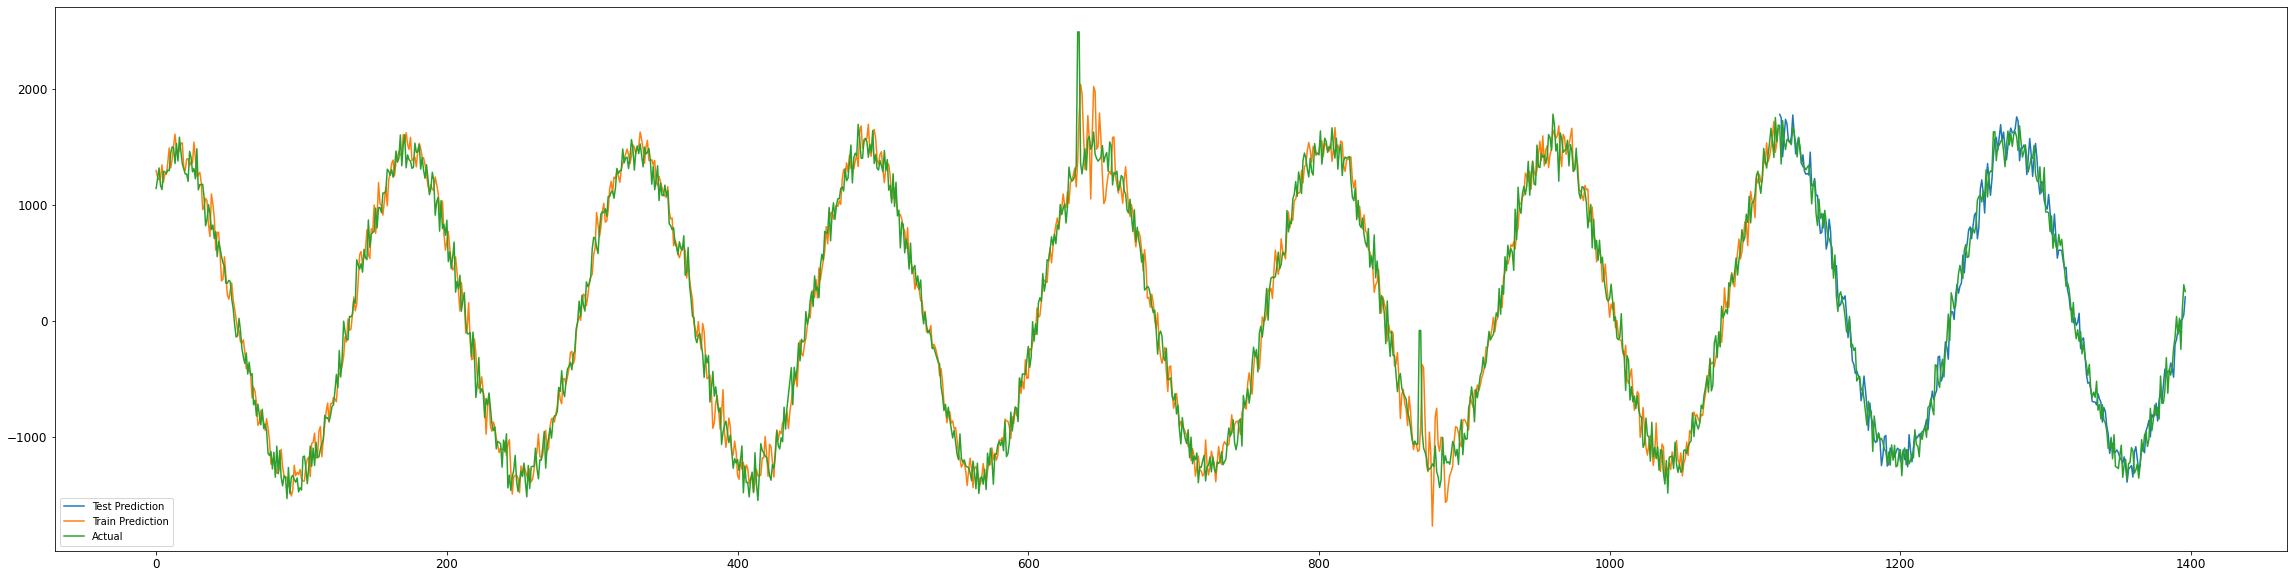

Deviation Min [2.99483901e-05], Max [0.27629191]
Deviation 99.7th pctile [0.17163151]
Deviation > 99.7th pctile is_anomaly labels in data (array([0, 1]), array([1392,    5]))
Actual is_anomaly labels in data (array([0, 1]), array([1393,    4]))
Confusion matrix 
[[1392    1]
 [   0    4]]
precision 0.80000, recall 1.00000, f1 0.88889
Time to train: 1953 ms


In [25]:
DIR = 'A2Benchmark'
Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DIRS_FILE_EXTENSIONS[DIR], recursive=True)
timeVariantColumns = ['value']
labelColumnNum = 2
pctile = 99.7
split = 0.8
look_back = 24
verbose = 0

metricsMap = {}
# do across all files in the benchmark. for now just the first one in glob list
for data_file in benchmark_files[:1]:
    metrics = {}
    print('File Name : ', data_file)
    data, lookBackTsData, Xtrain, Ytrain, Xtest, Ytest = get_train_test(data_file,
                                                                        timeVariantColumns,labelColumnNum,
                                                                        split, look_back)
    reshapedX = lookBackTsData[:, :look_back]
    reshapedY = lookBackTsData[:, look_back].reshape((-1,1))
    print("Shapes: Xtrain {}, Ytrain {}, Xtest {}, Ytest {}".format(Xtrain.shape, Ytrain.shape, Xtest.shape, Ytest.shape))
    scalerX, scaledXtrain, scaledXtest = scale(Xtrain, Xtest)
    scalerY, scaledYtrain, scaledYtest = scale(Ytrain, Ytest)
    start_millis = current_time_millis()
    model = train(Xtrain = scaledXtrain, Ytrain = scaledYtrain, batch_size = 32, verbose = verbose)
    end_millis = current_time_millis() 
    
    trainMSE, trainRMSE = evaluate_model(model = model, X = scaledXtrain, Y = scaledYtrain)
    print("Train Score: {0:.5f} MSE {1:.5f} RMSE".format(trainMSE, trainRMSE))
    testMSE, testRMSE = evaluate_model(model = model, X = scaledXtest, Y = scaledYtest)
    print("Test Score: {0:.5f} MSE {1:.5f} RMSE".format(testMSE, testRMSE))
    
    YtrainPredicted = predict(model = model, X = scaledXtrain)
    YtestPredicted = predict(model = model, X = scaledXtest)
    
    plot_actuals_vs_predictions(reshapedY,
                                scalerY.inverse_transform(YtrainPredicted),
                                scalerY.inverse_transform(YtestPredicted), look_back)
            
    # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
    labels = get_records_above_deviation_pctile(model, reshapedX, reshapedY, pctile)
    
    # actual is_anomaly labels in dataset
    actualLabels = (data[look_back:, labelColumnNum] != 0.0).astype('int')    
    print("Actual is_anomaly labels in data", np.unique(actualLabels, return_counts = True))
        
    # Compare calculated labels and actual labels to find TP, TN, FP, FN and F1, confusion matrix
    conf_matrix, prec, recall, f1 = get_classification_metrics(actualLabels, labels)
    print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall, f1))
    print("Time to train: {} ms".format(end_millis - start_millis))
    metrics['traintime'] = end_millis - start_millis
    metrics['conf_matrix'] = conf_matrix
    metrics['precision'] = prec
    metrics['recall'] = recall
    metrics['f1'] = f1
    metricsMap[data_file] = metrics


In [26]:
precisions=[]
recalls=[]
f1s=[]
times = []
for v in metricsMap.values():
    precisions.append(v['precision'])
    recalls.append(v['recall'])
    f1s.append(v['f1'])
    times.append(v['traintime'])
avg_prec = np.average(np.array(precisions))
avg_recall = np.average(np.array(recalls))
avg_f1 = np.average(np.array(f1s))
avg_time = np.average(np.array(times))
print("Avg precision {0:.5f} recall {1:.5f} f1 {2:.5f} time to train {3:.2f} ms".format(avg_prec, avg_recall, avg_f1, avg_time))

Avg precision 0.80000 recall 1.00000 f1 0.88889 time to train 1953.00 ms


# Model search

## KerasRegressor model wrapper

In [27]:
def get_train_validation(Xtrain, Ytrain, validation_ratio=0.1):
    validation_size = int(len(Xtrain) * validation_ratio)
    Xtrain, Xvalid = Xtrain[validation_size:], Xtrain[:validation_size]
    Ytrain, Yvalid = Ytrain[validation_size:], Ytrain[:validation_size]
    return Xtrain, Ytrain, Xvalid, Yvalid

In [28]:
def plot_training_history(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

In [29]:
def baseline_model(input_shape):
    def build_model(input_shape=input_shape, n_hidden = 1, n_units = 96, learning_rate = 0.001):
        model = keras.models.Sequential()
        model.add(keras.layers.InputLayer(input_shape=input_shape))
        for layer in range(n_hidden):
            model.add(keras.layers.Dense(n_units, activation="relu"))
        model.add(keras.layers.Dense(1))
        optimizer = keras.optimizers.Adam(lr=learning_rate)
        model.compile(loss="mse", optimizer=optimizer)
        return model
    return build_model

Try the keras regressor

In [30]:
keras.backend.clear_session()
DIR = 'A2Benchmark'
Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep 
benchmark_files = glob.glob(Benchmark_dir + DIRS_FILE_EXTENSIONS[DIR], recursive=True)
timeVariantColumns = ['value']
labelColumnNum = 2
pctile = 99.7
split = 0.8
look_back = 24

validation_ratio = 0.1
early_stop_patience = 5
epochs = 25
batch_size = 32
verbose = 0

# do across all files in the benchmark. for now just the first one in glob list
for data_file in benchmark_files[:1]:    
    print('File Name : ', data_file)
    data, lookBackTsData, Xtrain_full, Ytrain_full, Xtest, Ytest = get_train_test(data_file, timeVariantColumns,
                                                                                  labelColumnNum, split, look_back)
    print("Shapes: Xtrain_full {}, Ytrain_full {}, Xtest {}, Ytest {}".format(Xtrain_full.shape, Ytrain_full.shape, 
                                                                              Xtest.shape, Ytest.shape))
        
    scalerX, scaledXtrain_full, scaledXtest = scale(Xtrain_full, Xtest)
    scalerY, scaledYtrain_full, scaledYtest = scale(Ytrain_full, Ytest)
    
    Xtrain, Ytrain, Xvalid, Yvalid = get_train_validation(scaledXtrain_full, scaledYtrain_full,
                                                          validation_ratio=validation_ratio)
    
    print("Shapes: Xtrain {}, Ytrain {}, Xvalid {}, Yvalid {}".format(Xtrain.shape, Ytrain.shape, 
                                                                      Xvalid.shape, Yvalid.shape))
    
    keras_regressor = keras.wrappers.scikit_learn.KerasRegressor(build_fn=baseline_model(input_shape=Xtrain.shape[1:]))
    
    early_stopping_cb = keras.callbacks.EarlyStopping(patience=early_stop_patience, restore_best_weights = True)
    
    start_millis = current_time_millis()
    history = keras_regressor.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size,
                                 validation_data=(Xvalid, Yvalid),
                                 callbacks=[early_stopping_cb], verbose=verbose)
    
    end_millis = current_time_millis()
    print("Time to train: {} ms".format(end_millis - start_millis))
        
    trainMSE = - keras_regressor.score(scaledXtrain_full, scaledYtrain_full, verbose=verbose)
    print("Train Score: {0:.5f} MSE {1:.5f} RMSE".format(trainMSE, np.sqrt(trainMSE)))
    testMSE = - keras_regressor.score(scaledXtest, scaledYtest, verbose=verbose)
    print("Test Score: {0:.5f} MSE {1:.5f} RMSE".format(testMSE, np.sqrt(testMSE)))
    


File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A2Benchmark/synthetic_10.csv
Shapes: Xtrain_full (1117, 24), Ytrain_full (1117, 1), Xtest (280, 24), Ytest (280, 1)
Shapes: Xtrain (1006, 24), Ytrain (1006, 1), Xvalid (111, 24), Yvalid (111, 1)
Time to train: 2563 ms
Train Score: 0.00132 MSE 0.03627 RMSE
Test Score: 0.00086 MSE 0.02924 RMSE


## Randomized search with KerasRegressor

Parameters are mainly the number of hidden layers and units per hidden layer. The number of units could be same for each hidden layer. It really doesn't matter much.

In [31]:
param_distribs = {
    "n_hidden": np.arange(1, 5).tolist(), # upto 4 hidden layers
    "n_units": np.arange(24, 26).tolist() # 24-25 hidden layer units/neurons
}

**for now trying with the above small param distributions and 2 files per folder**.

Also unable to reduce the verbosity of the search.

In [32]:
timeVariantColumns = ['value']
labelColumnNum = 2
pctile = 99.7
split = 0.8
look_back = 24

validation_ratio = 0.1
early_stop_patience = 5
epochs = 25
batch_size = 32
n_iter = 1
cv = 3

verbose = 1
search_verbose = 0

results = {} # results from all folders

for DIR, extension in DIRS_FILE_EXTENSIONS.items():
    Benchmark_dir  = YAHOO_DS + os.path.sep + DIR + os.path.sep 
    benchmark_files = glob.glob(Benchmark_dir + extension, recursive=True)

    results[DIR]={} # results from this folder
    # do across all files in the benchmark. for now just the first 2 in glob list
    for data_file in benchmark_files[:2]:
        print('File Name : ', data_file)
        # or use get_train_test_shuffled() ??
        data, lookBackTsData, Xtrain_full, Ytrain_full, Xtest, Ytest = get_train_test(data_file, timeVariantColumns,
                                                                                      labelColumnNum, split, look_back)
        print("Shapes: Xtrain_full {}, Ytrain_full {}, Xtest {}, Ytest {}".format(Xtrain_full.shape, Ytrain_full.shape, 
                                                                                  Xtest.shape, Ytest.shape))

        scalerX, scaledXtrain_full, scaledXtest = scale(Xtrain_full, Xtest)
        scalerY, scaledYtrain_full, scaledYtest = scale(Ytrain_full, Ytest)

        Xtrain, Ytrain, Xvalid, Yvalid = get_train_validation(scaledXtrain_full, scaledYtrain_full, validation_ratio=0.1)

        print("Shapes: Xtrain {}, Ytrain {}, Xvalid {}, Yvalid {}".format(Xtrain.shape, Ytrain.shape, 
                                                                          Xvalid.shape, Yvalid.shape))
        keras.backend.clear_session()

        keras_regressor = keras.wrappers.scikit_learn.KerasRegressor(build_fn = baseline_model(input_shape=Xtrain.shape[1:]))

        early_stopping_cb = keras.callbacks.EarlyStopping(patience=early_stop_patience, restore_best_weights = True)

        rnd_search_cv = RandomizedSearchCV(keras_regressor, param_distribs, n_iter = n_iter, cv = cv, verbose = search_verbose)

        start_millis = current_time_millis()
        rnd_search_cv.fit(Xtrain, Ytrain, epochs=epochs, batch_size=batch_size, 
                                     validation_data=(Xvalid, Yvalid), 
                                     callbacks=[early_stopping_cb])

        end_millis = current_time_millis()

        model = rnd_search_cv.best_estimator_.model
        print("Best parameters {} best score {}:".format(rnd_search_cv.best_params_, -rnd_search_cv.best_score_))

        trainMSE = model.evaluate(scaledXtrain_full, scaledYtrain_full, verbose = verbose)
        print("Train Score: {0:.5f} MSE {1:.5f} RMSE".format(trainMSE, np.sqrt(trainMSE)))
        testMSE = model.evaluate(scaledXtest, scaledYtest, verbose = verbose)
        print("Test Score: {0:.5f} MSE {1:.5f} RMSE".format(testMSE, np.sqrt(testMSE)))       



        # predict on whole data set and plot - this would require extra work for shuffled train/test split case
    #     YtrainPredicted = model.predict(scaledXtrain_full)
    #     YtestPredicted = model.predict(scaledXtest)

        reshapedX = lookBackTsData[:, :look_back]
        reshapedY = lookBackTsData[:, look_back].reshape((-1,1))
    #     plot_actuals_vs_predictions(reshapedY,
    #                                 scalerY.inverse_transform(YtrainPredicted),
    #                                 scalerY.inverse_transform(YtestPredicted), look_back)

        # get deviations for whole dataset and id records with deviations > pctile threshold and asign an is_anomaly label
        predictedLabels = get_records_above_deviation_pctile(model, reshapedX, reshapedY, pctile)

        # actual is_anomaly labels in dataset
        actualLabels = (data[look_back:, labelColumnNum] != 0.0).astype('int')    
        print("Actual is_anomaly labels in data", np.unique(actualLabels, return_counts = True))

        # Compare calculated labels and actual labels to find TP, TN, FP, FN and F1, confusion matrix
        conf_matrix, prec, recall, f1 = get_classification_metrics(actualLabels, predictedLabels)
        print("Confusion matrix \n{0}\nprecision {1:.5f}, recall {2:.5f}, f1 {3:.5f}".format(conf_matrix, prec, recall, f1))
        print("Time to train: {} ms".format(end_millis - start_millis))
        file_results = {'model' : model, 'best params' : rnd_search_cv.best_params_, 'best score' : -rnd_search_cv.best_score_,
                       'traintime' : (end_millis - start_millis), 'train MSE' : trainMSE, 'test MSE' : testMSE,
                       'precision' : prec, 'recall' : recall, 'f1' : f1, 'confusion_matrix' : conf_matrix}
        results[DIR][data_file] = file_results

File Name :  ../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_4.csv
Shapes: Xtrain_full (1119, 24), Ytrain_full (1119, 1), Xtest (280, 24), Ytest (280, 1)
Shapes: Xtrain (1008, 24), Ytrain (1008, 1), Xvalid (111, 24), Yvalid (111, 1)
Epoch 1/25
21/21 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0020
Epoch 2/25
21/21 [==============================] - 0s 6ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 3/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 4/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0030 - val_loss: 0.0019
Epoch 5/25
21/21 [==============================] - 0s 9ms/step - loss: 0.0030 - val_loss: 0.0020
Epoch 6/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 7/25
21/21 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 8/25
21/21 [===========

22/22 [==============================] - 0s 5ms/step - loss: 0.0098 - val_loss: 0.0148
Epoch 11/25
22/22 [==============================] - 0s 6ms/step - loss: 0.0095 - val_loss: 0.0143
Epoch 12/25
22/22 [==============================] - 0s 6ms/step - loss: 0.0093 - val_loss: 0.0141
Epoch 13/25
22/22 [==============================] - 0s 6ms/step - loss: 0.0091 - val_loss: 0.0139
Epoch 14/25
22/22 [==============================] - 0s 9ms/step - loss: 0.0087 - val_loss: 0.0137
Epoch 15/25
22/22 [==============================] - 0s 8ms/step - loss: 0.0086 - val_loss: 0.0135
Epoch 16/25
22/22 [==============================] - 0s 9ms/step - loss: 0.0085 - val_loss: 0.0134
Epoch 17/25
22/22 [==============================] - 0s 6ms/step - loss: 0.0083 - val_loss: 0.0134
Epoch 18/25
22/22 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0134
Epoch 19/25
22/22 [==============================] - 0s 7ms/step - loss: 0.0080 - val_loss: 0.0131
Epoch 20/25
22/22 [===

Epoch 16/25
32/32 [==============================] - 0s 8ms/step - loss: 0.0126 - val_loss: 0.0136
Epoch 17/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0125 - val_loss: 0.0138
Epoch 18/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0123 - val_loss: 0.0135
Epoch 19/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0122 - val_loss: 0.0133
Epoch 20/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0119 - val_loss: 0.0139
Epoch 21/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0116 - val_loss: 0.0130
Epoch 22/25
32/32 [==============================] - 0s 5ms/step - loss: 0.0115 - val_loss: 0.0131
Epoch 23/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0112 - val_loss: 0.0129
Epoch 24/25
32/32 [==============================] - 0s 7ms/step - loss: 0.0113 - val_loss: 0.0124
Epoch 25/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0111 - val_loss: 0.0129
Best param

21/21 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 19/25
21/21 [==============================] - 0s 5ms/step - loss: 0.0015 - val_loss: 8.2633e-04
Epoch 20/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 21/25
11/11 [==============================] - 0s 2ms/step - loss: 0.0020
Epoch 1/25
32/32 [==============================] - 0s 11ms/step - loss: 0.0472 - val_loss: 0.0142
Epoch 2/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0022
Epoch 3/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 4/25
32/32 [==============================] - 0s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 5/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0018 - val_loss: 0.0012
Epoch 6/25
32/32 [==============================] - 0s 6ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 7/25
32/32 [========================

21/21 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 19/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 20/25
21/21 [==============================] - 0s 10ms/step - loss: 0.0036 - val_loss: 0.0018
Epoch 21/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 22/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0034 - val_loss: 0.0020
Epoch 23/25
21/21 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0018
Epoch 24/25
21/21 [==============================] - 0s 7ms/step - loss: 0.0033 - val_loss: 0.0019
Epoch 25/25
11/11 [==============================] - 0s 3ms/step - loss: 0.0079
Epoch 1/25
21/21 [==============================] - 0s 13ms/step - loss: 0.0340 - val_loss: 0.0058
Epoch 2/25
21/21 [==============================] - 0s 6ms/step - loss: 0.0097 - val_loss: 0.0054
Epoch 3/25
21/21 [=======================

25/25 [==============================] - 0s 9ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 5/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 6/25
25/25 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 7/25
25/25 [==============================] - 0s 17ms/step - loss: 8.8962e-04 - val_loss: 9.8971e-04
Epoch 8/25
25/25 [==============================] - 0s 8ms/step - loss: 6.3819e-04 - val_loss: 7.8023e-04
Epoch 9/25
25/25 [==============================] - 0s 6ms/step - loss: 4.6713e-04 - val_loss: 3.9181e-04
Epoch 10/25
25/25 [==============================] - 0s 8ms/step - loss: 4.0878e-04 - val_loss: 2.8335e-04
Epoch 11/25
25/25 [==============================] - 0s 12ms/step - loss: 3.6396e-04 - val_loss: 2.7309e-04
Epoch 12/25
25/25 [==============================] - 0s 8ms/step - loss: 3.4908e-04 - val_loss: 2.1283e-04
Epoch 13/25
25/25 [==============================] - 0s 8ms/step - loss: 3.4

25/25 [==============================] - 0s 13ms/step - loss: 0.2405 - val_loss: 0.1351
Epoch 2/25
25/25 [==============================] - 0s 6ms/step - loss: 0.1107 - val_loss: 0.0965
Epoch 3/25
25/25 [==============================] - 0s 5ms/step - loss: 0.0866 - val_loss: 0.0701
Epoch 4/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0617 - val_loss: 0.0500
Epoch 5/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0444 - val_loss: 0.0337
Epoch 6/25
25/25 [==============================] - 0s 10ms/step - loss: 0.0318 - val_loss: 0.0229
Epoch 7/25
25/25 [==============================] - 0s 5ms/step - loss: 0.0227 - val_loss: 0.0154
Epoch 8/25
25/25 [==============================] - 0s 5ms/step - loss: 0.0168 - val_loss: 0.0104
Epoch 9/25
25/25 [==============================] - 0s 5ms/step - loss: 0.0129 - val_loss: 0.0080
Epoch 10/25
25/25 [==============================] - 0s 5ms/step - loss: 0.0108 - val_loss: 0.0064
Epoch 11/25
25/25 [=========

38/38 [==============================] - 0s 7ms/step - loss: 0.0093 - val_loss: 0.0065
Epoch 9/25
38/38 [==============================] - 0s 6ms/step - loss: 0.0089 - val_loss: 0.0070
Epoch 10/25
38/38 [==============================] - 0s 5ms/step - loss: 0.0087 - val_loss: 0.0062
Epoch 11/25
38/38 [==============================] - 0s 5ms/step - loss: 0.0086 - val_loss: 0.0063
Epoch 12/25
38/38 [==============================] - 0s 5ms/step - loss: 0.0085 - val_loss: 0.0064
Epoch 13/25
38/38 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.0065
Epoch 14/25
38/38 [==============================] - 0s 4ms/step - loss: 0.0082 - val_loss: 0.0062
Epoch 15/25
38/38 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.0057
Epoch 16/25
38/38 [==============================] - 0s 4ms/step - loss: 0.0079 - val_loss: 0.0057
Epoch 17/25
38/38 [==============================] - 0s 8ms/step - loss: 0.0078 - val_loss: 0.0057
Epoch 18/25
38/38 [====

25/25 [==============================] - 0s 7ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 10/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 11/25
25/25 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0023
Epoch 12/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 13/25
25/25 [==============================] - 0s 14ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 14/25
25/25 [==============================] - 0s 5ms/step - loss: 0.0027 - val_loss: 0.0020
Epoch 15/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0026 - val_loss: 0.0022
Epoch 16/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 17/25
25/25 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0019
Epoch 18/25
25/25 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 19/25
25/25 [==

Epoch 7/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0034 - val_loss: 0.0039
Epoch 8/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0025 - val_loss: 0.0034
Epoch 9/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0020 - val_loss: 0.0028
Epoch 10/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0017 - val_loss: 0.0021
Epoch 11/25
25/25 [==============================] - 0s 10ms/step - loss: 0.0015 - val_loss: 0.0019
Epoch 12/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0019
Epoch 13/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0013 - val_loss: 0.0018
Epoch 14/25
25/25 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0018
Epoch 15/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 16/25
25/25 [==============================] - 0s 7ms/step - loss: 0.0011 - val_loss: 0.0015
Epoch 17/25


## Results dump

**Decide if it would be better to calculate the deviations and classification metrics as a second pass and leave search to just find the best model.**. We see quite a wild variation in mean/max/qth pctile deviation across files.

In [34]:
print(results)

{'A1Benchmark': {'../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_4.csv': {'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f2bc004e280>, 'best params': {'n_units': 24, 'n_hidden': 2}, 'best score': 0.002123736485373229, 'traintime': 15333, 'train MSE': 0.0020247758366167545, 'test MSE': 0.2109421342611313, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0, 'confusion_matrix': array([[1394,    0],
       [   0,    5]])}, '../Stochastic-Methods/data/yahoo/dataset/ydata-labeled-time-series-anomalies-v1_0/A1Benchmark/real_37.csv': {'model': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f2ba4171b50>, 'best params': {'n_units': 24, 'n_hidden': 2}, 'best score': 0.014719342968116203, 'traintime': 23071, 'train MSE': 0.01075515802949667, 'test MSE': 0.05563870072364807, 'precision': 0.2, 'recall': 0.029411764705882353, 'f1': 0.05128205128205128, 'confusion_matrix': array([[1372,    4],
       [  33,   